# Recommendation Engine

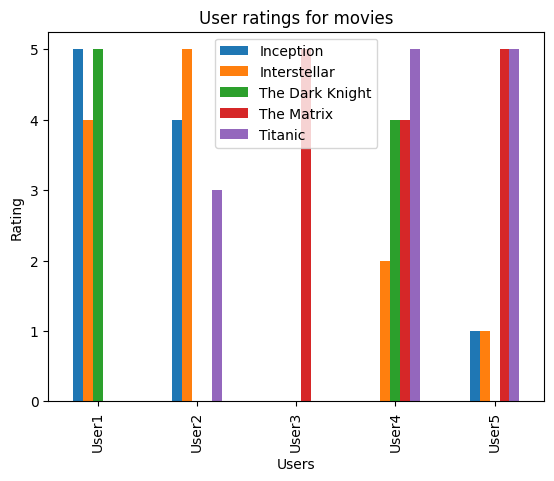

Recommendations for User3:
Titanic            6.027614
The Dark Knight    2.048590
Interstellar       1.717670
dtype: float64


In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample user-item rating matrix
data = {
    'Inception': [5, 4, 0, 0, 1],
    'Interstellar': [4, 5, 0, 2, 1],
    'The Dark Knight': [5, 0, 0, 4, 0],
    'The Matrix': [0, 0, 5, 4, 5],
    'Titanic': [0, 3, 0, 5, 5]
}

users = ['User1', 'User2', 'User3', 'User4', 'User5']
df = pd.DataFrame(data, index=users)

# Plot the dataframe using matplotlib

df.plot(kind='bar')
plt.title('User ratings for movies')
plt.xlabel('Users')
plt.ylabel('Rating')
plt.show()

# Compute user similarity
similarity = cosine_similarity(df)
similarity_df = pd.DataFrame(similarity, index=users, columns=users)

# Function to recommend movies for a given user
def recommend(user, top_n=3):
    if user not in df.index:
        return "User not found."
    
    # Get similar users
    similar_users = similarity_df[user].sort_values(ascending=False)[1:]
    
    # Weighted sum of ratings from similar users
    weighted_ratings = pd.Series(dtype=float)
    for other_user, sim_score in similar_users.items():
        weighted_ratings = weighted_ratings.add(df.loc[other_user] * sim_score, fill_value=0)
    
    # Remove movies the user has already rated
    user_rated = df.loc[user][df.loc[user] > 0].index
    weighted_ratings = weighted_ratings.drop(user_rated, errors='ignore')
    
    # Recommend top N movies
    recommendations = weighted_ratings.sort_values(ascending=False).head(top_n)
    return recommendations

# Example usage
print("Recommendations for User3:")
print(recommend('User3'))

# Use Gen AI to recommend movies

In [12]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
  azure_endpoint = "https://aifsweden.openai.azure.com/", 
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

response = client.responses.create(
    model="gpt-5-mini",
    #temperature=0.7,
    reasoning={"effort": "low"},
    input="""Take this data and tell what user 3 should watch next:""" + df.to_json(),
)

print(response.output_text)



Summary: Recommend "Titanic" for User3.

How I got that (brief):
- User3 has only rated The Matrix (5).
- The other users who also rated The Matrix are User4 (4) and User5 (5). I used those as neighbors and weighted their ratings by their Matrix scores (weights 4 and 5).
- Predicted ratings for User3 (weighted average):

  - Titanic: (5*4 + 5*5) / (4+5) = 45/9 = 5.0
  - The Dark Knight: (4*4 + 0*5) / 9 = 16/9 ≈ 1.78
  - Interstellar: (2*4 + 1*5) / 9 = 13/9 ≈ 1.44
  - Inception: (0*4 + 1*5) / 9 = 5/9 ≈ 0.56

Because Titanic has the highest predicted rating (5.0), that's the recommended next watch for User3.


# Try to speed up

In [16]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
  azure_endpoint = "https://aifsweden.openai.azure.com/", 
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

response = client.responses.create(
    model="gpt-5-nano",
    #temperature=0.7,
    reasoning={"effort": "low"},
    input="""Take this data and tell what user 3 should watch next:""" + df.to_json(),
)

print(response.output_text)



Recommendation for User 3: Titanic

Reasoning:
- User 3 has rated only The Matrix highly (5). Among the remaining unviewed titles, Titanic has the highest average rating from other users (2.6) compared to Inception (2.0), Interstellar (2.4), and The Dark Knight (1.8).
- Titanic is a popular pick with strong cross-user ratings, making it a solid next-choice based on collaborative filtering.

If you want a closer genre vibe to The Matrix (sci-fi), Interstellar is another strong option, though its predicted average is a bit lower.


# Remove the internet (foundry local)

In [5]:
import openai
#pip install foundry-local-sdk
from foundry_local import FoundryLocalManager

# By using an alias, the most suitable model will be downloaded 
# to your end-user's device.
#alias = "phi-3.5-mini"

alias = "Phi-3.5-mini-instruct-generic-gpu"

# Create a FoundryLocalManager instance. This will start the Foundry 
# Local service if it is not already running and load the specified model.
manager = FoundryLocalManager(alias)

# The remaining code us es the OpenAI Python SDK to interact with the local model.

# Configure the client to use the local Foundry service
client = openai.OpenAI(
    base_url=manager.endpoint,
    api_key=manager.api_key,  # API key is not required for local usage
)

# Set the model to use and generate a streaming response
stream = client.chat.completions.create(
    model=manager.get_model_info(alias).id,
    messages=[{"role": "user", "content": "Take this data and tell what user3 should watch next (just the answer and confidnece):" + df.to_json(),}],
    stream=True,
    max_tokens=4000,
    temperature=0.7,
    top_p=0.9,
)

# Print the streaming response
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="", flush=True)

 Based on the ratings given by the users, User3 seems to have a preference for "The Matrix" with a high rating of 5. To watch something similar, User3 might enjoy the next film with a strong science fiction or action elements, similar to "The Matrix." Considering the available options and User3's interest, they might want to watch "Inception," as it also has a high rating from User1 and a moderate rating from User2, indicating some level of interest in complex narratives and action.

Answer: Inception

Confidence: Moderate (User3 has not rated "Inception," but it shares thematic elements with "The Matrix," which they highly rated.)